# Russian - English translator

## Load data
### Source: https://opus.nlpl.eu/sample/ru&en/QED&v2.0a/sample

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
from parsers import load_parallel_texts

# Specify the paths to your dataset files
russian_file_path = 'datasets/tatoeba/Tatoeba.en-ru.ru'
english_file_path = 'datasets/tatoeba/Tatoeba.en-ru.en'

# Load the dataset
dataset = load_parallel_texts(russian_file_path, english_file_path)


### Data Analyze

In [4]:
from data_analyze import show_random, stat
    
show_random(dataset, 5)

RU: Но когда я попытался включить душ, полилась эта черная пузырящаяся жидкость.
EN: But when I tried to turn the shower faucet, this black bubbly liquid came out.

RU: Не знаю, хватит ли у меня смелости попросить у неё номер телефона.
EN: I don't know if I have the courage to ask for her number.

RU: Я повернула направо.
EN: I turned right.

RU: Как нам вытащить её из тюрьмы?
EN: How do we get her out of jail?

RU: Я не хочу, чтобы он меня видел.
EN: I don't want him to see me.



Length: 540675
Russian Mean: 5.39, SD: 2.67
English Mean: 6.25, SD: 3.01
Unique Russian words: 149408
Unique English words: 62104


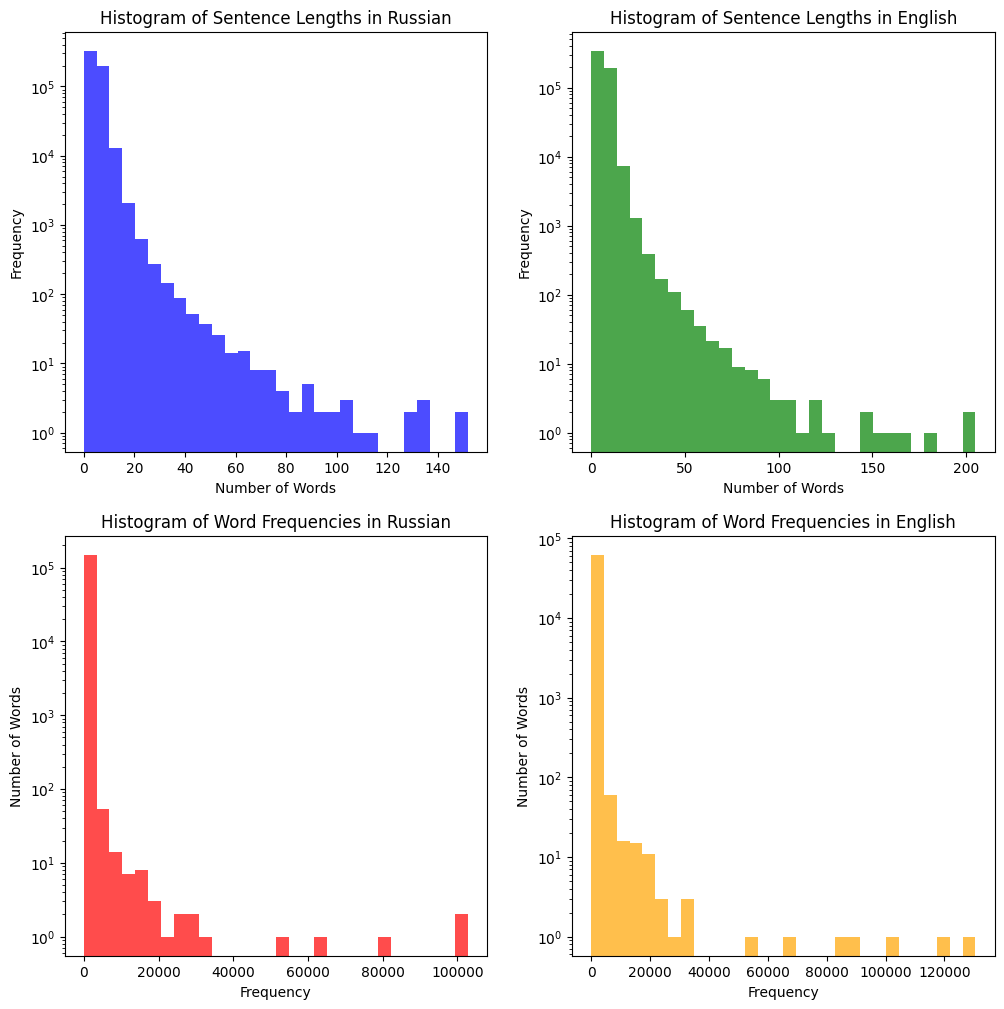

In [5]:
stat(dataset, log=True)

### Data normalization

('this is a sample text for processing .', 'это пример текста для обработки .')


100%|██████████| 540675/540675 [57:01<00:00, 158.03it/s]


RU: том поцеловать ей рука , вогнать её в краска .
EN: Tom kiss her hand , make her blush .

RU: мочь я помочь ?
EN: can I help ?

RU: в близкий будущее космический путешествие больше не быть всего лишь мечта .
EN: in the near future , space travel will no long be just a dream .

RU: я тебе час в пять позвоню .
EN: I will call you around five o'clock .

RU: я вас не приглашать .
EN: I do not invite you .

Length: 540675
Russian Mean: 6.84, SD: 3.33
English Mean: 7.73, SD: 3.47
Unique Russian words: 42403
Unique English words: 23532


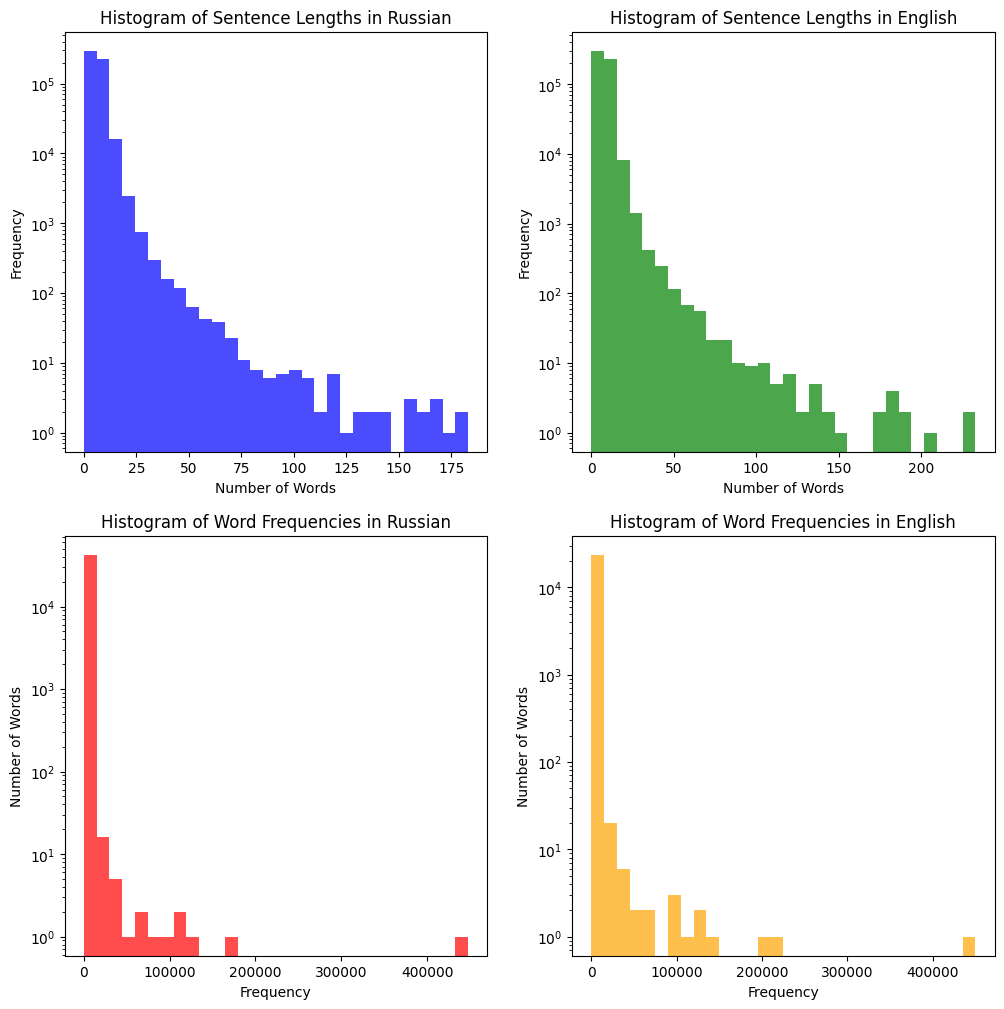

In [38]:
import spacy
from tqdm import tqdm

from data_norm import limitisation
from parsers import write_to_file

normalized_data = limitisation(dataset)

show_random(normalized_data, 5)
stat(normalized_data, True)

write_to_file(normalized_data, "norm_data.txt")

RU: мы хотеть с ней поговорить .
EN: we want to talk to she .

RU: я всё рассказать мама .
EN: I tell my mom everything .

RU: мочь ей верить .
EN: you can believe she .

RU: я обычно ходить на рынок по пятница .
EN: I usually go to market on Friday .

RU: я путешествовать .
EN: I travel .

Length: 540675
Russian Mean: 6.84, SD: 3.33
English Mean: 7.73, SD: 3.47
Unique Russian words: 42403
Unique English words: 23532


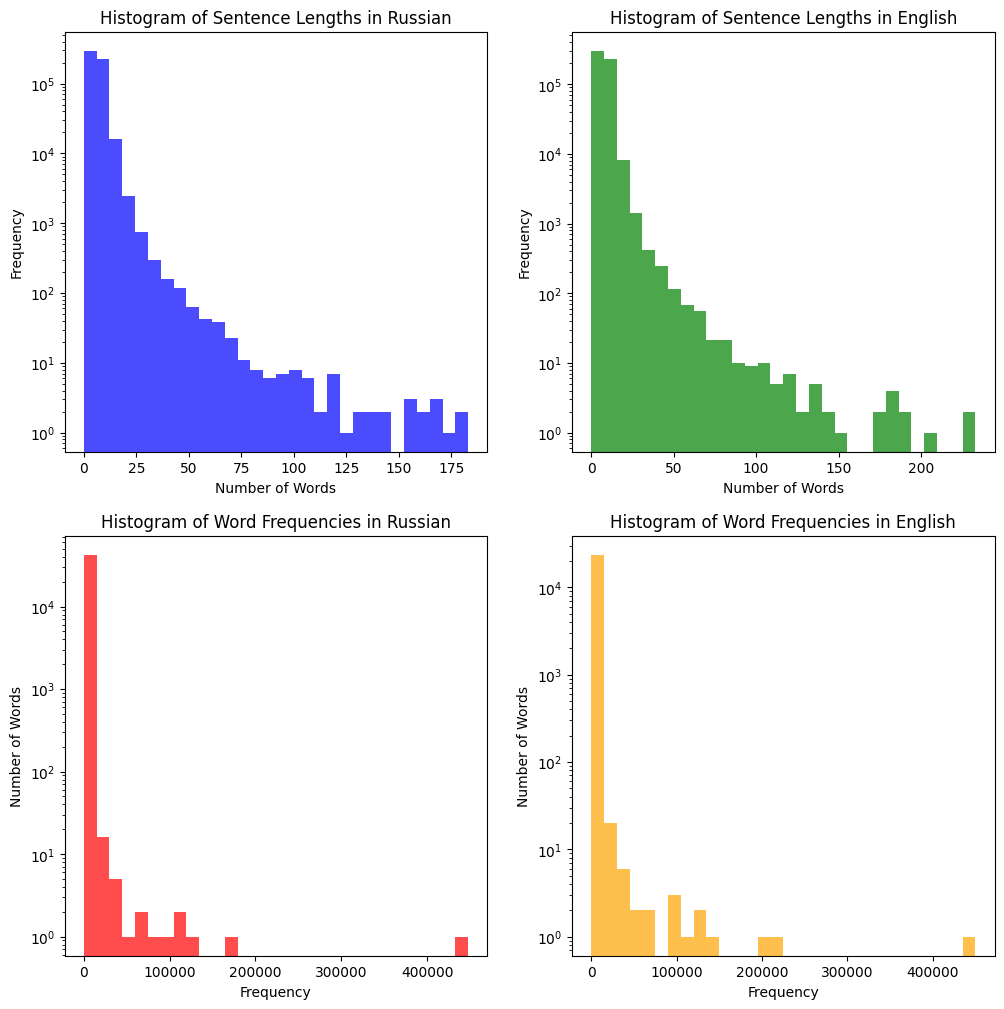

In [7]:
from parsers import load_one_file_texts

normalized_data = load_one_file_texts("datasets/norm_data.txt")

show_random(normalized_data, 5)
stat(normalized_data, True)

RU: том хороший певец .
EN: Tom be a good singer .

RU: примерь этот рубашка .
EN: try on that shirt .

RU: он не верить свой глаз .
EN: he do not believe his eye .

RU: том неплохо рассказывать анекдот .
EN: Tom be pretty good at tell joke .

RU: полиция допрашивать их .
EN: the police be question they .

Length: 486608
Russian Mean: 6.15, SD: 1.83
English Mean: 7.02, SD: 1.80
Unique Russian words: 34870
Unique English words: 18538


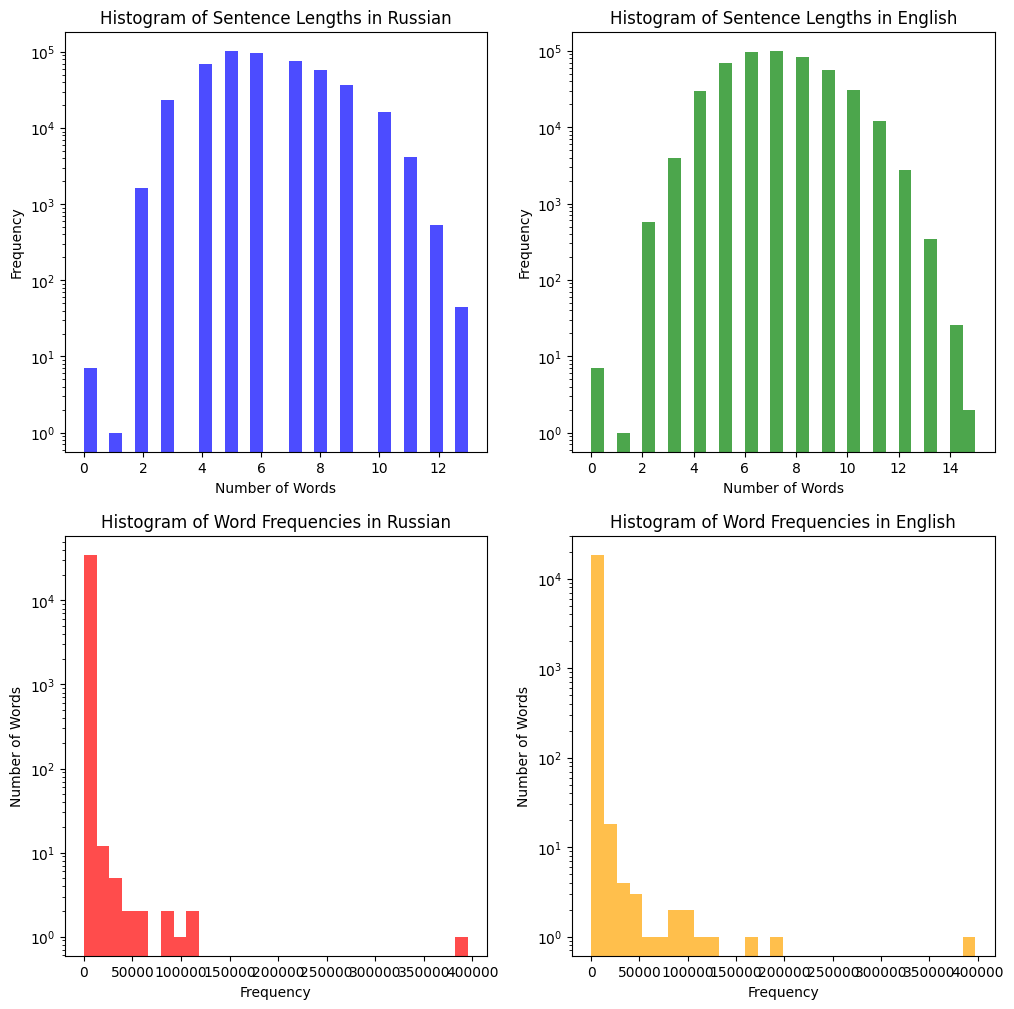

In [8]:
def filter_sentence_lengths(data, shortest_percent, longest_percent):
    # Sort the dataset by the mean length of the sentences in each pair
    dataset_sorted = sorted(data, key=lambda pair: (len(pair[0].split()) + len(pair[1].split())) / 2)
    
    # Calculate the number of sentences to remove from the shortest and longest ends
    length = len(data)
    
    # Slice the sorted dataset to remove the shortest and longest sentences
    filtered_dataset = dataset_sorted[int(length * shortest_percent):length - int(length * longest_percent)]
    
    return filtered_dataset

normalized_data = filter_sentence_lengths(dataset, 0, 0.1)

show_random(normalized_data, 5)
stat(normalized_data, True)

In [9]:
# batch:
# <sos> привет <eos> <pad> <pad>
# <sos> привет как   дела <eos>


class Vocabulary:
    special_tokens = {
        '<pad>': 0,  # Padding token
        '<sos>': 1,  # Start of sentence
        '<eos>': 2,  # End of sentence
        '<unk>': 3   # Unknown word
    }

    def __init__(self, sentences, max_size):

        self.index_to_token = {}
        self.token_to_index = {}
        
        # Initialize vocabulary with special tokens
        for token, index in self.special_tokens.items():
            self.token_to_index[token] = index
            self.index_to_token[index] = token

        # Count the frequency of each word
        word_freq = Counter(word for sentence in sentences for word in sentence.split())

        # Keep the most common words up to max_size
        most_common_words = word_freq.most_common(max_size-len(self.special_tokens))

        # add most common words to the vocabulary
        for word, _ in most_common_words:
            index = len(self.token_to_index)
            self.token_to_index[word] = index
            self.index_to_token[index] = word


    def tokenize(self, sentence):
        tokenized_seq = [self.special_tokens.get('<sos>')]
        tokenized_seq += [self.token_to_index.get(token, self.special_tokens['<unk>']) for token in sentence.split()]
        tokenized_seq.append(self.special_tokens.get('<eos>'))
        return tokenized_seq


    def detokenize(self, tokens):
        # General detokenization, excluding '<sos>', '<eos>', and '<pad>'
        detokenized = ' '.join(self.index_to_token[token] for token in tokens if token > self.special_tokens['<unk>'])
        return detokenized


    def bleu_detokenize(self, tokens):
        # Detokenize specifically for BLEU calculation, stripping out '<sos>', '<eos>', '<pad>', and '<unk>'
        meaningful_tokens = [token for token in tokens if token > self.special_tokens['<unk>']]
        detokenized = ' '.join(self.index_to_token[token] for token in meaningful_tokens if token not in self.special_tokens.values())
        return detokenized


    def __len__(self):
        return len(self.token_to_index)

In [10]:
ru_sentences, en_sentences = zip(*normalized_data)

RU_VOCAB_SIZE=34800
EN_VOCAB_SIZE=18500


ru_vocab = Vocabulary(ru_sentences, RU_VOCAB_SIZE)
en_vocab = Vocabulary(en_sentences, EN_VOCAB_SIZE)

ru_vocab.index_to_token
en_vocab.index_to_token


In [11]:
print(len(ru_vocab))
print(len(en_vocab))

34800
18500


In [12]:
from torch.utils.data import DataLoader, Dataset, random_split
import torch
from torch.nn.utils.rnn import pad_sequence


class TranslationDataset(Dataset):
    def __init__(self, src_tensors, trg_tensors):
        self.src_tensors = src_tensors
        self.trg_tensors = trg_tensors

    def __len__(self):
        return len(self.src_tensors)

    def __getitem__(self, idx):
        src_tensor = self.src_tensors[idx]
        trg_tensor = self.trg_tensors[idx]
        return src_tensor, trg_tensor



ru_tensors = [torch.tensor(ru_vocab.tokenize(sentence), dtype=torch.long) for sentence in ru_sentences]
en_tensors = [torch.tensor(en_vocab.tokenize(sentence), dtype=torch.long) for sentence in en_sentences]


# Assuming tensor_dataset is a combined list of (ru_tensor, en_tensor) pairs
tensor_dataset = list(zip(ru_tensors, en_tensors))

split_ratios=(0.75, 0.25) # train_size, valid_size
batch_size = 128

# Calculate sizes of splits
train_size = int(len(tensor_dataset) * split_ratios[0])
valid_size = len(tensor_dataset) - train_size

# Split the dataset
train_dataset, valid_dataset = torch.utils.data.random_split(tensor_dataset, [train_size, valid_size])

# Wrap with TranslationDataset
train_dataset = TranslationDataset(*zip(*train_dataset))
valid_dataset = TranslationDataset(*zip(*valid_dataset))


def collate_fn(batch):
    src_batch, trg_batch = zip(*batch)
    src_batch_padded = pad_sequence(src_batch, batch_first=True, padding_value=ru_vocab.special_tokens['<pad>'])
    trg_batch_padded = pad_sequence(trg_batch, batch_first=True, padding_value=en_vocab.special_tokens['<pad>'])
    return src_batch_padded, trg_batch_padded


# Create DataLoader instances for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [13]:
import torch.nn as nn


class Seq2SeqLSTM(nn.Module):
    def __init__(
            self,
            input_size,
            output_size,
            embedding_decoder_dim,
            embedding_encoder_dim,
            hidden_decoder_dim,
            hidden_encoder_dim,
            num_decoder_layers,
            num_encoder_layers,
            dropout_rate
):
        
        super(Seq2SeqLSTM, self).__init__()
        
        # Define the embedding layer for the source language with input_size and embedding_dim
        self.encoder_embedding = nn.Embedding(
            num_embeddings=input_size,
            embedding_dim=embedding_encoder_dim
        )
        
        # Define the LSTM encoder with embedding_dim, hidden_dim, num_layers
        self.encoder_lstm = nn.LSTM(
            input_size=embedding_encoder_dim,
            hidden_size=hidden_encoder_dim,
            num_layers=num_encoder_layers,
            batch_first=True,
            dropout=dropout_rate
        )
        
        # Define the embedding layer for the decoder
        self.decoder_embedding = nn.Embedding(
            num_embeddings=output_size,
            embedding_dim=embedding_decoder_dim
        )
        
        # Define the LSTM decoder with embedding_dim, hidden_dim, num_layers
        self.decoder_lstm = nn.LSTM(
            input_size=embedding_decoder_dim,
            hidden_size=hidden_decoder_dim,
            num_layers=num_decoder_layers,
            batch_first=True,
            dropout=dropout_rate
        )
        
        # Define the fully connected layer to map the decoder outputs to the target vocabulary size
        self.fc_out = nn.Linear(
            in_features=hidden_decoder_dim,
            out_features=output_size
        )

        # Define the dropout regularization
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, input_seq, target_seq=None, teacher_forcing_ratio=0.5, max_length=50):
        if self.training:
            # Training mode: target_seq is required for teacher forcing
            return self._forward_train(input_seq, target_seq, teacher_forcing_ratio)
        else:
            # Inference mode: generate output sequence without target_seq
            return self._forward_infer(input_seq, max_length)
    

    def _forward_train(self, input_seq, target_seq, teacher_forcing_ratio):

        batch_size, target_len = target_seq.size()
        output_size = self.fc_out.out_features

        # Initialize the output tensor to store the decoder's predictions
        outputs = torch.zeros(batch_size, target_len, output_size).to(input_seq.device)

        # Embed the input sequence
        encoder_embedded = self.dropout(self.encoder_embedding(input_seq))

        # Encoder
        _, (hidden, cell) = self.encoder_lstm(encoder_embedded)
        
        # Prepare the first input to the decoder, which is <sos> tokens
        decoder_input = torch.tensor([[Vocabulary.special_tokens['<sos>']] for _ in range(batch_size)], device=input_seq.device)

        # Decoder
        for t in range(1, target_len):
            decoder_embedded = self.dropout(self.decoder_embedding(decoder_input))
            decoder_output, (hidden, cell) = self.decoder_lstm(decoder_embedded, (hidden, cell))

            output = self.fc_out(decoder_output.squeeze(1))
            outputs[:, t, :] = output
            
            # Decide whether to use teacher forcing
            teacher_force = np.random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            decoder_input = (target_seq[:, t] if teacher_force else top1).unsqueeze(1)
            
        return outputs


    def _forward_infer(self, input_seq, max_length):
        batch_size = input_seq.size(0)
        output_size = self.fc_out.out_features
        outputs = torch.zeros(batch_size, max_length, output_size).to(input_seq.device)
        
        # Encoder
        encoder_embedded = self.dropout(self.encoder_embedding(input_seq))
        _, (hidden, cell) = self.encoder_lstm(encoder_embedded)

        # Decoder
        decoder_input = torch.tensor([Vocabulary.special_tokens['<sos>']] * batch_size).to(input_seq.device)  # Assume SOS_token is defined
        for t in range(1, max_length):
            decoder_embedded = self.dropout(self.decoder_embedding(decoder_input).unsqueeze(1))
            decoder_output, (hidden, cell) = self.decoder_lstm(decoder_embedded, (hidden, cell))
            output = self.fc_out(decoder_output.squeeze(1))
            outputs[:, t, :] = output
            
            # Get the highest probability token
            top1 = output.max(1)[1]
            decoder_input = top1
            
            # Stop at EOS tokens (you'll need to define EOS_token)
            if (top1 == Vocabulary.special_tokens['<eos>']).all():
                break
                
        return outputs
    

def init_weights(model):
    for name, param in model.named_parameters():
        if 'weight_ih' in name:  # LSTM input-hidden weights
            nn.init.xavier_uniform_(param.data)
        elif 'weight_hh' in name:  # LSTM hidden-hidden weights
            nn.init.orthogonal_(param.data)
        elif 'bias' in name:  # Biases
            param.data.fill_(0)
        elif 'weight' in name:  # Linear layer weights
            nn.init.xavier_uniform_(param.data)
        elif 'embedding' in name:  # Embedding weights
            nn.init.uniform_(param.data, -0.1, 0.1)

### BLEU score

Target: two cats and a dog

Hypothesis: two cats and three dogs

Unigrams:
    Target Unigrams: two, cats, and, a, dog
    Hypothesis Unigrams: two, cats, and, three, dogs

    Total Unigrams in Hypothesis: 5
    Matching Unigrams: 3 (two, cats, and)
    P1 = Unigram Precision: Matching Unigrams / Total Unigrams in Hypothesis = 3/5 = 0.6

Bigrams:
    Target Bigrams: (two, cats), (cats, and), (and, a), (a, dog)
    Hypothesis Bigrams: (two, cats), (cats, and), (and, three), (three, dogs)

    Total Bigrams in Hypothesis: 4
    Matching Bigrams: 2 ((two, cats), (cats, and))
    P2 = Bigram Precision: Matching Bigrams / Total Bigrams in Hypothesis = 2/4 = 0.5

BLEU score = sqrt(P1​×P2)​ = 0.548

In [14]:
import torch
from torch import optim
import progressbar
from nltk.translate.bleu_score import corpus_bleu


train_losses = []
train_epoch_losses = []
valid_losses = []
valid_epoch_losses = []

def train_model(
        model,
        train_loader,
        valid_loader,
        num_epochs,
        learning_rate,
        weight_decay,
        teacher_forcing_ratio=0.0,
        name='v1'
):



    # Use CrossEntropyLoss for classification tasks
    criterion = nn.CrossEntropyLoss(ignore_index=Vocabulary.special_tokens['<pad>'])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_loss = 0

        bar = progressbar.ProgressBar(maxval=len(train_loader)).start()
        idx = 0

        for input_tensors, target_tensors in train_loader:

            optimizer.zero_grad()  # Clear gradients

            output = model(
                input_seq=input_tensors,
                target_seq=target_tensors,
                teacher_forcing_ratio=teacher_forcing_ratio
            )
            
            # Compute loss; assuming output shape is [batch_size, seq_len, output_size]
            # and target shape is [batch_size, seq_len]
            loss = criterion(output.view(-1, output.size(-1)), target_tensors.view(-1))
            loss.backward()  # Backpropagate
            optimizer.step()  # Update weights

            total_loss += loss.item()

            train_losses.append(loss.item())

            bar.update(idx)
            idx += 1

        avg_train_loss = total_loss / len(train_loader)

        train_epoch_losses.append(avg_train_loss)

        # Validation loop
        model.eval()  # Set model to evaluation mode
        total_val_loss = 0
        references = []
        hypotheses = []

        with torch.no_grad():
            for input_tensors, target_tensors in valid_loader:
                output = model(input_tensors, max_length=target_tensors.shape[1])
                loss = criterion(output.view(-1, output.size(-1)), target_tensors.view(-1))
                total_val_loss += loss.item()
                valid_losses.append(loss.item())

                # Convert model output and target tensors to word indices
                # Assuming output is [batch_size, seq_len, output_size]
                output_indices = output.argmax(2)  # Get the index of the max log-probability
                
                for i in range(output_indices.size(0)):
                    # Convert target tensor indices to words, excluding special tokens
                    ref = en_vocab.bleu_detokenize(target_tensors[i].tolist())
                    # Convert hypothesis (model output) indices to words, excluding special tokens
                    hyp = en_vocab.bleu_detokenize(output_indices[i].tolist())
                    references.append([ref.split()])  # BLEU expects tokenized sentences as a list of words
                    hypotheses.append(hyp.split())

        avg_val_loss = total_val_loss / len(valid_loader)
        valid_epoch_losses.append(avg_val_loss)
        bleu_score = corpus_bleu(references, hypotheses)

        torch.save(model.state_dict(), f'backup/model_{name}_epoch_{epoch}')

        print(f'''Epoch {epoch+1}:
              Train Loss: {avg_train_loss:.4f},
              Validation Loss: {avg_val_loss:.4f},
              BLUE score: {bleu_score:.4f}''')

    print("Training complete.")

In [59]:
model = Seq2SeqLSTM(
    input_size=RU_VOCAB_SIZE,
    output_size=EN_VOCAB_SIZE,
    embedding_decoder_dim=64,
    embedding_encoder_dim=64,
    hidden_decoder_dim=64,
    hidden_encoder_dim=64,
    num_decoder_layers=4,
    num_encoder_layers=4,
    dropout_rate=0.6
)

model.apply(init_weights)


train_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    num_epochs=10,
    learning_rate=0.001,
    weight_decay=1e-4,
    teacher_forcing_ratio=0.5,
    name='v1_1'
)

Epoch 1:
              Train Loss: 5.2101,
              Validation Loss: 5.1296,
              BLUE score: 0.0000
Epoch 2:
              Train Loss: 4.6157,
              Validation Loss: 4.7061,
              BLUE score: 0.0276
Epoch 3:
              Train Loss: 4.4257,
              Validation Loss: 4.5493,
              BLUE score: 0.0422
Epoch 4:
              Train Loss: 4.3130,
              Validation Loss: 4.4099,
              BLUE score: 0.0483
Epoch 5:
              Train Loss: 4.2231,
              Validation Loss: 4.3195,
              BLUE score: 0.0614
Epoch 6:
              Train Loss: 4.1477,
              Validation Loss: 4.2257,
              BLUE score: 0.0759
Epoch 7:
              Train Loss: 4.0871,
              Validation Loss: 4.1613,
              BLUE score: 0.0824
Epoch 8:
              Train Loss: 4.0398,
              Validation Loss: 4.1210,
              BLUE score: 0.0895
Epoch 9:
              Train Loss: 4.0043,
              Validation Loss: 4.0786

In [62]:
model = Seq2SeqLSTM(
    input_size=RU_VOCAB_SIZE,
    output_size=EN_VOCAB_SIZE,
    embedding_decoder_dim=128,
    embedding_encoder_dim=128,
    hidden_decoder_dim=128,
    hidden_encoder_dim=128,
    num_decoder_layers=4,
    num_encoder_layers=4,
    dropout_rate=0.6
)

model.apply(init_weights)


train_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    num_epochs=10,
    learning_rate=0.0015,
    weight_decay=1e-4,
    teacher_forcing_ratio=0.5,
    name='v1_2'
)

Epoch 1:
              Train Loss: 4.8276,
              Validation Loss: 4.3593,
              BLUE score: 0.0482


Epoch 2:
              Train Loss: 4.1980,
              Validation Loss: 4.0075,
              BLUE score: 0.0804


Epoch 3:
              Train Loss: 3.9772,
              Validation Loss: 3.8409,
              BLUE score: 0.1046


Epoch 4:
              Train Loss: 3.8574,
              Validation Loss: 3.7278,
              BLUE score: 0.1261


Epoch 5:
              Train Loss: 3.7690,
              Validation Loss: 3.6398,
              BLUE score: 0.1436


Epoch 6:
              Train Loss: 3.7030,
              Validation Loss: 3.5841,
              BLUE score: 0.1529


Epoch 7:
              Train Loss: 3.6557,
              Validation Loss: 3.5304,
              BLUE score: 0.1683


Epoch 8:
              Train Loss: 3.6197,
              Validation Loss: 3.5037,
              BLUE score: 0.1696


Epoch 9:
              Train Loss: 3.5905,
              Validation Loss: 3.4611,
              BLUE score: 0.1773


Epoch 10:
              Train Loss: 3.5620,
              Validation Loss: 3.4374,
              BLUE score: 0.1848
Training complete.


In [63]:
model = Seq2SeqLSTM(
    input_size=RU_VOCAB_SIZE,
    output_size=EN_VOCAB_SIZE,
    embedding_decoder_dim=128,
    embedding_encoder_dim=128,
    hidden_decoder_dim=128,
    hidden_encoder_dim=128,
    num_decoder_layers=4,
    num_encoder_layers=4,
    dropout_rate=0.7
)

model.apply(init_weights)


train_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    num_epochs=10,
    learning_rate=0.0017,
    weight_decay=1e-5,
    teacher_forcing_ratio=0.3,
    name='v1_3'
)

Epoch 1:
              Train Loss: 4.7131,
              Validation Loss: 4.2879,
              BLUE score: 0.0541


Epoch 2:
              Train Loss: 4.0558,
              Validation Loss: 3.9020,
              BLUE score: 0.1004


Epoch 3:
              Train Loss: 3.7851,
              Validation Loss: 3.6758,
              BLUE score: 0.1357


Epoch 4:
              Train Loss: 3.6261,
              Validation Loss: 3.5304,
              BLUE score: 0.1656


Epoch 5:
              Train Loss: 3.5178,
              Validation Loss: 3.4243,
              BLUE score: 0.1929


Epoch 6:
              Train Loss: 3.4403,
              Validation Loss: 3.3450,
              BLUE score: 0.2093


Epoch 7:
              Train Loss: 3.3813,
              Validation Loss: 3.2872,
              BLUE score: 0.2277


Epoch 8:
              Train Loss: 3.3353,
              Validation Loss: 3.2476,
              BLUE score: 0.2412


Epoch 9:
              Train Loss: 3.2982,
              Validation Loss: 3.2150,
              BLUE score: 0.2525


Epoch 10:
              Train Loss: 3.2641,
              Validation Loss: 3.1707,
              BLUE score: 0.2622
Training complete.


In [14]:
model = Seq2SeqLSTM(
    input_size=RU_VOCAB_SIZE,
    output_size=EN_VOCAB_SIZE,
    embedding_decoder_dim=100,
    embedding_encoder_dim=100,
    hidden_decoder_dim=150,
    hidden_encoder_dim=150,
    num_decoder_layers=4,
    num_encoder_layers=4,
    dropout_rate=0.5
)

model.apply(init_weights)


train_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    num_epochs=10,
    learning_rate=0.002,
    weight_decay=1e-5,
    teacher_forcing_ratio=0.4,
    name='v1_4'
)

Epoch 1:
              Train Loss: 4.6766,
              Validation Loss: 4.1531,
              BLUE score: 0.0811


Epoch 2:
              Train Loss: 3.7204,
              Validation Loss: 3.6041,
              BLUE score: 0.1712


Epoch 3:
              Train Loss: 3.3575,
              Validation Loss: 3.3252,
              BLUE score: 0.2485


Epoch 4:
              Train Loss: 3.1505,
              Validation Loss: 3.1451,
              BLUE score: 0.2977


Epoch 5:
              Train Loss: 3.0234,
              Validation Loss: 3.0514,
              BLUE score: 0.3353


Epoch 6:
              Train Loss: 2.9390,
              Validation Loss: 2.9806,
              BLUE score: 0.3533


Epoch 7:
              Train Loss: 2.8824,
              Validation Loss: 2.9589,
              BLUE score: 0.3683


Epoch 8:
              Train Loss: 2.8390,
              Validation Loss: 2.9178,
              BLUE score: 0.3836


Epoch 9:
              Train Loss: 2.8049,
              Validation Loss: 2.8825,
              BLUE score: 0.3877


Epoch 10:
              Train Loss: 2.7778,
              Validation Loss: 2.8558,
              BLUE score: 0.3986
Training complete.


In [16]:
model = Seq2SeqLSTM(
    input_size=RU_VOCAB_SIZE,
    output_size=EN_VOCAB_SIZE,
    embedding_decoder_dim=150,
    embedding_encoder_dim=150,
    hidden_decoder_dim=100,
    hidden_encoder_dim=100,
    num_decoder_layers=4,
    num_encoder_layers=4,
    dropout_rate=0.5
)

model.apply(init_weights)


train_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    num_epochs=15,
    learning_rate=0.002,
    weight_decay=1e-5,
    teacher_forcing_ratio=0.4,
    name='v1_5'
)

Epoch 1:
              Train Loss: 4.7070,
              Validation Loss: 4.2419,
              BLUE score: 0.0687


Epoch 2:
              Train Loss: 3.8287,
              Validation Loss: 3.6889,
              BLUE score: 0.1483


Epoch 3:
              Train Loss: 3.4817,
              Validation Loss: 3.4400,
              BLUE score: 0.2085


Epoch 4:
              Train Loss: 3.2897,
              Validation Loss: 3.2855,
              BLUE score: 0.2572


Epoch 5:
              Train Loss: 3.1749,
              Validation Loss: 3.1700,
              BLUE score: 0.2869


Epoch 6:
              Train Loss: 3.0915,
              Validation Loss: 3.1027,
              BLUE score: 0.3099


Epoch 7:
              Train Loss: 3.0300,
              Validation Loss: 3.0573,
              BLUE score: 0.3289


Epoch 8:
              Train Loss: 2.9842,
              Validation Loss: 3.0136,
              BLUE score: 0.3398


Epoch 9:
              Train Loss: 2.9543,
              Validation Loss: 2.9864,
              BLUE score: 0.3509


Epoch 10:
              Train Loss: 2.9202,
              Validation Loss: 2.9548,
              BLUE score: 0.3579


Epoch 11:
              Train Loss: 2.8958,
              Validation Loss: 2.9350,
              BLUE score: 0.3623


Epoch 12:
              Train Loss: 2.8751,
              Validation Loss: 2.9275,
              BLUE score: 0.3706


Epoch 13:
              Train Loss: 2.8572,
              Validation Loss: 2.9133,
              BLUE score: 0.3738


Epoch 14:
              Train Loss: 2.8438,
              Validation Loss: 2.8896,
              BLUE score: 0.3795


Epoch 15:
              Train Loss: 2.8306,
              Validation Loss: 2.8894,
              BLUE score: 0.3803
Training complete.


In [16]:
model = Seq2SeqLSTM(
    input_size=RU_VOCAB_SIZE,
    output_size=EN_VOCAB_SIZE,
    embedding_decoder_dim=128,
    embedding_encoder_dim=128,
    hidden_decoder_dim=256,
    hidden_encoder_dim=256,
    num_decoder_layers=4,
    num_encoder_layers=4,
    dropout_rate=0.5
)

model.apply(init_weights)

 
train_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    num_epochs=20,
    learning_rate=0.002,
    weight_decay=1e-5,
    teacher_forcing_ratio=0.4,
    name='v1_6'
)

Epoch 1:
              Train Loss: 4.9411,
              Validation Loss: 4.2076,
              BLUE score: 0.0722


Epoch 2:
              Train Loss: 3.6385,
              Validation Loss: 3.4378,
              BLUE score: 0.2237


Epoch 3:
              Train Loss: 3.1525,
              Validation Loss: 3.1153,
              BLUE score: 0.3181


Epoch 4:
              Train Loss: 2.9330,
              Validation Loss: 2.9611,
              BLUE score: 0.3612


Epoch 5:
              Train Loss: 2.8123,
              Validation Loss: 2.8684,
              BLUE score: 0.3947


Epoch 6:
              Train Loss: 2.7355,
              Validation Loss: 2.8250,
              BLUE score: 0.4145


Epoch 7:
              Train Loss: 2.6757,
              Validation Loss: 2.7666,
              BLUE score: 0.4269


Epoch 8:
              Train Loss: 2.6405,
              Validation Loss: 2.7543,
              BLUE score: 0.4413


Epoch 9:
              Train Loss: 2.6116,
              Validation Loss: 2.7473,
              BLUE score: 0.4491


Epoch 10:
              Train Loss: 2.5842,
              Validation Loss: 2.6958,
              BLUE score: 0.4501


Epoch 11:
              Train Loss: 2.5627,
              Validation Loss: 2.6741,
              BLUE score: 0.4511


Epoch 12:
              Train Loss: 2.5432,
              Validation Loss: 2.6792,
              BLUE score: 0.4624


Epoch 13:
              Train Loss: 2.5274,
              Validation Loss: 2.6657,
              BLUE score: 0.4685


Epoch 14:
              Train Loss: 2.5178,
              Validation Loss: 2.6657,
              BLUE score: 0.4711


KeyboardInterrupt: 